In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
import scipy.spatial
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)

* http://www.cs.ubc.ca/~nando/540-2013/lectures.html
* https://www.youtube.com/watch?v=w2OtwL5T1ow&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6
* http://videolectures.net/gpip06_mackay_gpb/
* http://www.robots.ox.ac.uk/~mebden/reports/GPtutorial.pdf
* http://www.gaussianprocess.org/gpml/chapters/RW2.pdf
* https://en.wikipedia.org/wiki/Schur_complement#Schur_complement_condition_for_positive_definiteness
* http://blog.sigopt.com/post/130275376068/sigopt-fundamentals-intuition-behind-gaussian

## Gaussian process

A [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) (GP) is a distribution $p(f)$ over functions $f(\mathbf{x})=y$. A function can be thought of as a infinite vector where each element corresponds to a function value $f(\mathbf{x})=y$ at a specific input $\mathbf{x}$.
A Gaussian process is defined so that it associates a Gaussian distributed random variable (TODO: intermezzo) $y$ for every point in the input space $\mathbf{x} \in \mathbb{R}^D$ such that any finite subset $(y_1 ... y_n)$ of these random variables is a joint Gaussian distribution (TODO: intermezzo). Since the GP defines a variable $y$ for every point $\mathbf{x}$ it is a distribution of functions $f(\mathbf{x})$. A Gaussian process model is completely specified by its mean and covariance (TODO: intermezzo) functions:

$$p(f) = \mathcal{GP}(m(X),C(X,X)), \quad f:\mathbb{R}^d \rightarrow \mathbb{R}$$

With $p(f)$ the distribution of $f$ and $X$ the data with dimension $d$. The mean $m(X)$ and covariance $C(X,X)$ are a function of $X$: (TODO: link to intermezzo)

$$m(X) = \mathbb{E}[f(X)]$$

$$C(X,X') = \mathbb{E}[(f(X)-m(X))(f(X')-m(X'))] $$

Note that the mean of the outputs and the covariance between the outputs are written as functions of the inputs.

## Kernel function

The [covariance](https://en.wikipedia.org/wiki/Covariance_function) can be modelled by a [kernel](https://en.wikipedia.org/wiki/Positive-definite_kernel) function $K(X,Y)$ that models how much the samples from $X$ and $Y$ change together. $K(X,Y)$ is positive if there is some similarity between the samples and will be zero if the samples are completely independent.

### Radial basis function kernel
A popular kernel is the [radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF) kernel: 

$$K(X,Y) = e^{\textstyle \left( -\frac{1}{2\sigma^2} \lVert X-Y \rVert^2 \right)} $$

This kernel is illustrated in the next figure which shows the distance with respect to $0$: $K(0,y)$. Note that the similarity outputted by the kernel decreases exponentially towards $0$ the farther we move move away from the center, and that the similarity is maximum at the center $\mathbf{x}=\mathbf{y}$. Also note that the parameter $\sigma$ defines how fast the similarity decreases. This means that the output of the RBF kernel function $K(\mathbf{x},\mathbf{y})$ is a similarity based on how close $\mathbf{x}$ lies to $\mathbf{y}$, the greater $\sigma$ is, the greater this distance effect.

### Prior
The specification of this covariance function implies a distribution over functions $f(X)$. By choosing a specific kernel function $K$ it possible to set some [prior](https://en.wikipedia.org/wiki/Prior_probability) information on this distribution. For example the RBF kernel captures the prior information that the data lies in a [smooth](https://en.wikipedia.org/wiki/Smoothness) space. This is because it is infinitely differentiable over its full range. I will illustrate this more later in this tutorial.

### Valid kernels
In order to be a valid kernel function the resulting kernel matrix should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix). Which means that the matrix should be [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix) since $K(\mathbf{x},\mathbf{y}) = K(\mathbf{y},\mathbf{x})$, and that the output of the kernel function should be positive ($K(\mathbf{x},\mathbf{y}) \geq 0$). Being positive definite also means that the kernel matrix is [invertable](https://en.wikipedia.org/wiki/Invertible_matrix).

In [2]:
# Define the RBF kernel
def rbf_kernel(x, y, sigma):
    """Radial Basis Function (RBF) kernel"""
    sqNorm = np.square(x) + np.square(y).T - 2*np.dot(x, y.T)  # (a-b)^2 = a^2 + b^2 - 2ab
    return np.exp(-(1.0/(2*sigma**2) * sqNorm))

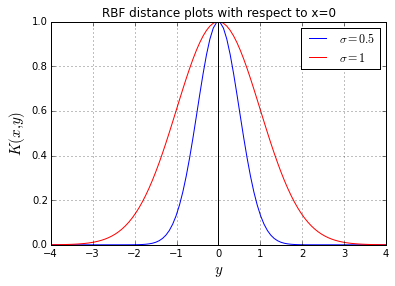

In [3]:
# Plot some kernel values of y with respect to 0
x = np.linspace(-4, 4, num=100)
zero = np.matrix([[0]])
y1 = [rbf_kernel(zero, np.matrix([[xi]]), 0.5)[0,0] for xi in x]
y2 = [rbf_kernel(zero, np.matrix([[xi]]), 1)[0,0] for xi in x]
# Make the plots
plt.plot(x, y1, 'b-', label="$\sigma=0.5$")
plt.plot(x, y2, 'r-', label="$\sigma=1$")
plt.plot((0, 0), (0, 1), 'k-')
plt.xlabel('$y$', fontsize=15)
plt.ylabel('$K(x,y)$', fontsize=15)
plt.title('RBF distance plots with respect to x=0')
plt.grid()
plt.legend(loc=1)
plt.show()

Cholesky decomposition requires your matrix to be positive definite. If your matrix supposed to be positive definite, you can add a small jitter (e.g. 10−5) to the diagonal of the matrix until it becomes a positive definite matrix. If your derivation is
wrong, then don’t bother it.
http://home.in.tum.de/~xiaoh/emmemo.pdf

The specification of this covariance function implies a distribution over functions $f(X)$. By choosing a specific kernel function $K$ it possible to set some prior information on this distribution.


### Sampling from prior:

The modelling of the covariance function as a kernel function implies a prior distribution over functions. It is possible to sample from this prior at any number of points.  
To sample from a prior with mean $m(\mathbf{x})=0$ and kernel $K(\mathbf{x},\mathbf{x})$ we can pick a number of input points $X$ and create the corresponding covariance matrix defined by  $K(X,X)=K$). Since $f(X)=\mathbf{y}$ is a random Guassian vector we can sample $\mathbf{y}$ from $\mathbf{y} \sim \mathcal{N}(0,K)$

#### Sample from multivariate Gaussian distribution

The intermezzo (TODO: link) shows us how we can sample form this multivariate Gaussian distribution with the help of the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) $K = L * L^\top$.  
We can sample from the standart normal distribution $Z \sim \mathcal{N}(0, I_d)$ and transform the results with $L$:

$$\mathbf{y} \sim L\mathcal{N}(0,I_d)$$ 

We illustrate this below by sampling at discrete points from $\mathcal{N}(0,I_d)$ with [`np.random.normal`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) and taking the dot product of this with $L$. We sample discrete points from 5 functions, each function in a different color. Note that each of them is quite smooth since the RBF kernel function acts as a smoothness prior.

Note: It might be needed to add some [jitter](https://en.wikipedia.org/wiki/Tikhonov_regularization) to the kernel to ensure it is positive definite in order to do the Cholesky decomposition. The kernel matrix should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix), but might not be because of numerical [precision](https://en.wikipedia.org/wiki/Precision_(computer_science%29).

In [4]:
# Sample from the prior
nb_of_samples = 75  # number of test points.
X = np.matrix(np.linspace(-4, 4, nb_of_samples)).T  # Sample from standard normal
K = rbf_kernel(X, X, sigma=1)  # Kernel of data points

# Draw samples from the prior at our data points.
L = np.linalg.cholesky(K + 1e-14 * np.eye(nb_of_samples))
y_prior = L.dot(np.random.normal(size=(nb_of_samples,5)))

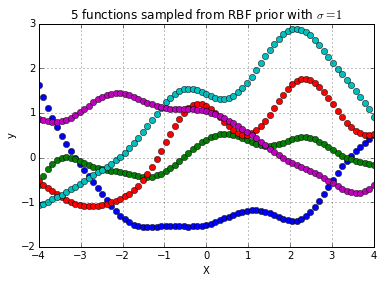

In [5]:
# Plot the sampled functions
plt.plot(X, y_prior, 'o')
plt.xlabel('X')
plt.ylabel('y')
plt.title('5 functions sampled from RBF prior with $\sigma=1$')
plt.grid()
plt.show()

### RBF kernel as smooth prior

Note that the identity matrix $I$ contains ones on the diagonal and zeros everywhere else. This means that all samples taken from $\mathcal{N}(0,I)$ are independent of eachother and we can just sample each sample seperately. These independent samples are then transformed with the help of the linear transformation $L$ that maps the independent samples to a space where they are more correlated. This correlation is defined by the kernel matrix $K=LL^\top$.  
The next figures illustrate how increasing the width $\sigma$ of the kernel increases it smoothnes.

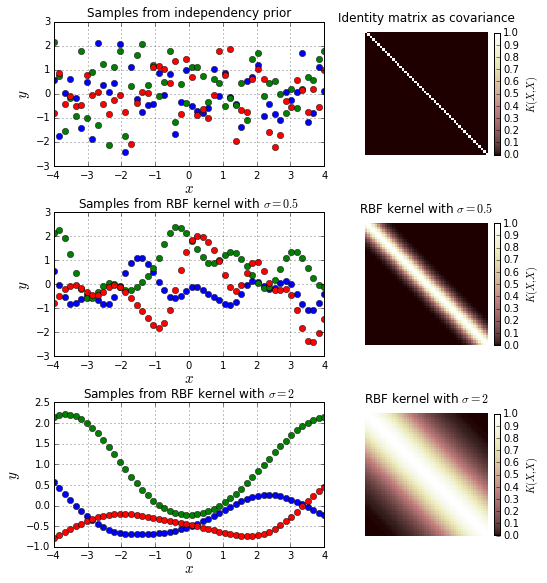

In [6]:
# Show samples from GPs defined by a RBF kernel with different widths
nb_of_samples = 50 # number of test points.
nb_of_functions = 3
# Generate independent samples that can be transformed
X = np.matrix(np.linspace(-4, 4, nb_of_samples)).T
y_independent = np.random.normal(size=(nb_of_samples,nb_of_functions))

fig = plt.figure(figsize=(8, 12)) 
gs0 = gridspec.GridSpec(3, 1)

# Plot no kernel (correlation=0)
# Sample from the prior (no prior)
K_0 = np.eye(nb_of_samples)
L_0 = np.linalg.cholesky(K_0 + 1e-14 * np.eye(nb_of_samples))
y_0 = L_0.dot(y_independent)
# Plot
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=[2,1], height_ratios=[1,1], subplot_spec=gs0[0])
# Plot samples
ax1 = plt.subplot(gs00[0])
ax1.plot(X, y_0, 'o')
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_xlabel('$x$', fontsize=15, labelpad=0)
ax1.grid()
ax1.set_title('Samples from independency prior')
# Plot covariance matrix
ax2 = plt.subplot(gs00[1])
im = ax2.matshow(K_0, cmap=cm.pink)
cbar = plt.colorbar(im, ax=ax2, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$K(X,X)$', fontsize=10)
ax2.set_title('Identity matrix as covariance')
ax2.set_frame_on(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

# Plot RBF with sigma=0.5
# Sample from the prior
K_05 = rbf_kernel(X, X, sigma=0.5) # Kernel at test points.
L_05 = np.linalg.cholesky(K_05 + 1e-14 * np.eye(nb_of_samples))
y_05 = L_05.dot(y_independent)
# Plot
gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=[2,1], height_ratios=[1,1], subplot_spec=gs0[1])
# Plot samples
ax1 = plt.subplot(gs01[0])
ax1.plot(X, y_05, 'o')
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_xlabel('$x$', fontsize=15, labelpad=0)
ax1.grid()
ax1.set_title('Samples from RBF kernel with $\sigma=0.5$')
# Plot covariance matrix
ax2 = plt.subplot(gs01[1])
im = ax2.matshow(K_05, cmap=cm.pink)
cbar = plt.colorbar(im, ax=ax2, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$K(X,X)$', fontsize=10)
ax2.set_title('RBF kernel with $\sigma=0.5$')
ax2.set_frame_on(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

# Plot RBF with sigma=2
# Sample from the prior
K_2 = rbf_kernel(X, X, sigma=2) # Kernel at test points.
L_2 = np.linalg.cholesky(K_2 + 1e-14 * np.eye(nb_of_samples))
y_2 = L_2.dot(y_independent)
# Plot
gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=[2,1], height_ratios=[1,1], subplot_spec=gs0[2])
# Plot samples
ax1 = plt.subplot(gs02[0])
ax1.plot(X, y_2, 'o')
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_xlabel('$x$', fontsize=15, labelpad=0)
ax1.grid()
ax1.set_title('Samples from RBF kernel with $\sigma=2$')
# Plot covariance matrix
ax2 = plt.subplot(gs02[1])
im = ax2.matshow(K_2, cmap=cm.pink)
cbar = plt.colorbar(im, ax=ax2, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$K(X,X)$', fontsize=10)
ax2.set_title('RBF kernel with $\sigma=2$')
ax2.set_frame_on(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

gs0.update(wspace=0.1, hspace=-0.34) # Put subplots closer together
plt.show()

## Making predictions from data
 
To make predictions $\mathbf{y}_2$ for new samples $X_2$ from observed data $(X_1,\mathbf{y}_1)$ we can sample from the [posterior](https://en.wikipedia.org/wiki/Posterior_probability) distribution $p(\mathbf{y}_2 \mid X_2,X_1,\mathbf{y}_1)$. $\mathbf{y}_1$ and $\mathbf{y}_2$ are jointly Gaussian since they should come both from the same function. We can write:  

$$
\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right]
\left[ \begin{array}{cc}
K_{11} & K_{12} \\
K_{21} & K_{22}
\end{array} \right]
\right)
$$

Where $\mu_{1}=m(X_1)$, $\mu_{2}=m(X_2)$, $K_{11}=K(X_1,X_1)$, $K_{22}=K(X_2,X_2)$, $K_{12}=K(X_1,X_2)$, and $K_{21}=K(X_2,X_1)$ with $K_{12} = K_{21}^T$. Note that $K_{11}$ is independent of $K_{22}$ and vice versa.

The intermezzo (TODO: link) explains how we  can get the conditional distribution:

$$\begin{split}
p(y_2 \mid X_2, X_1, y_1) & =  \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}) \\
\mu_{2|1} & = \mu(X_2) + K_{21} K_{11}^{-1} (\mathbf{y}_1 - \mu(X_1)) \\
                    & = K_{21} K_{11}^{-1} \mathbf{y}_1 \quad (\text{assume mean prior }  \mu = 0 ) \\
\Sigma_{2|1} & =  K_{22} - K_{21} K_{11}^{-1}K_{12}
\end{split}$$

It is then possible to sample from this posterior distribution by:

$$\mathbf{y}_{2} \sim L_{21} \mathcal{N}(0,I_d) + \mu_{2|1}$$

Where $\Sigma_{2|1}=L_{21}L_{21}^\top$.  
These formula give us a way to sample from the posterior distribution. We can calculate them efficiently with the help of the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). Note that $K = LL^\top$ means that $K^{-1} = L^{-\top} L^{-1}$

$$\begin{split}
\mu_{2|1} & = K_{21} K_{11}^{-1} \mathbf{y}_1 \\
          & = K_{21} L_{11}^{-\top} L_{11}^{-1} \mathbf{y}_1\\
          & = \frac{K_{21}}{L_{11}^\top} \frac{\mathbf{y}_1}{L_{11}}
\end{split}$$

$$\begin{split}
\Sigma_{2|1} & = K_{22} - K_{21} K_{11}^{-1} K_{12} \\
             & = K_{22} - K_{21} L_{11}^{-\top} L_{11}^{-1} K_{12} \\
             & = K_{22} - \frac{K_{21}}{L_{11}^\top} \frac{K_{12}}{L_{11}}
\end{split}$$

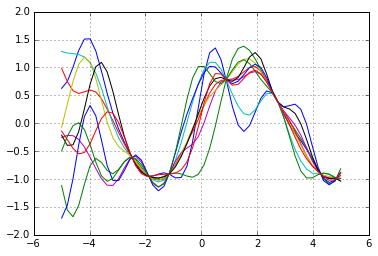

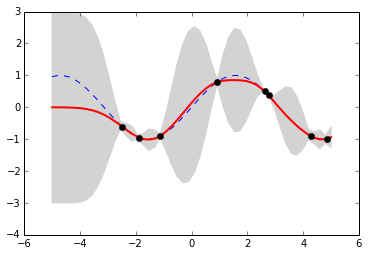

In [41]:
# This is the true unknown function we are trying to approximate
f = lambda x: (np.sin(x)).flatten()

N = 8       # number of training points.
n = 50         # number of test points.
nf = 10 # Number of samples
sigma=0.75

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X1 = np.random.uniform(-5, 5, size=(N,1))
y1 = f(X1)

K11 = rbf_kernel(X1, X1, sigma)
L11 = np.linalg.cholesky(K11 + 1e-14 * np.eye(N))

# points we're going to make predictions at.
X2 = np.linspace(-5, 5, n).reshape(-1,1)

K12 = rbf_kernel(X1, X2, sigma)
# compute the mean at our test points.
LK12 = np.linalg.solve(L11, K12)  # K12 / L
Ly1 = np.linalg.solve(L11, y1)  # y / L
mu = LK12.T.dot(Ly1)

# Compute the covariance
K22 = rbf_kernel(X2, X2, sigma)
S21 = K22 - LK12.T.dot(LK12)
# compute the variance at our test points.
s2 = np.diag(K_22) - np.sum(LK12**2, axis=0)
s = np.sqrt(s2)

# draw samples from the posterior at our test points.
L21 = np.linalg.cholesky(S21 + 1e-14*np.eye(n))
y2 = mu.reshape(-1,1) + L21.dot(np.random.normal(size=(n,nf)))


plt.figure(1)
plt.plot(X2, y2, '-')
plt.grid()
plt.show()

# Show predictive
plt.figure(2)

plt.plot(X2, f(X2), 'b--')
plt.gca().fill_between(X2.flat, mu-3*s, mu+3*s, color='lightgrey')
plt.plot(X2, mu, 'r-', lw=2)
plt.plot(X1, y1, 'ko', linewidth=2)
plt.show()

In [ ]:

""" This is code for simple GP regression. It assumes a zero mean GP Prior """

np.random.seed(seed=1)

# This is the true unknown function we are trying to approximate
f = lambda x: (np.sin(0.9*x)).flatten()
#f = lambda x: (0.25*(x**2)).flatten()




N = 10       # number of training points.
n = 50         # number of test points.
s = 0.00005    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

In [ ]:
np.random.seed(seed=1)
# PLOTS:
pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=20)
pl.plot(Xtest, f(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])
print('fig 1 created')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')
print('fig 2 created')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')
print('fig 3 created')

pl.show()